In [49]:
# Make imports 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import DistilBertTokenizer, DistilBertModel

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_device(1)

In [62]:
# Set random seeds for reproducible results

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Get the Dataset

In [34]:
# !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xvzf aclImdb_v1.tar.gz
# !rm aclImdb_v1.tar.gz
data_dir = './aclImdb/'

In [59]:
# reference code: https://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-and-dataset.html

def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    df = pd.DataFrame()
    df['review'] = data
    df['label'] = labels
    return df

def get_tokenized_dataset(data, tokenizer):
    tokenized_reviews = data.review.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))

    max_len = max(map(len,tokenized_reviews))
    padded_reviews = np.array([i+[0]*(max_len-len(i))  for i in tokenized_reviews])
    attention_masked_reviews = np.where(padded_reviews!=0,1,0)

    X = torch.from_numpy(padded_reviews)
    X_attention = torch.from_numpy(attention_masked_reviews)
    y = torch.from_numpy(data.label.to_numpy())
    
    return X, X_attention, y

In [ ]:
# Define tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
train_data = read_imdb(data_dir, is_train=True)
test_data = read_imdb(data_dir, is_train=False)

X_train, X_attn_train, y_train = get_tokenized_dataset(train_data, tokenizer)
X_test, X_attn_test, y_test = get_tokenized_dataset(test_data, tokenizer)

In [63]:
# split trainset and create dataloaders

batch_size = 16

X_train, X_val, X_attn_train, X_attn_val, y_train, y_val = train_test_split(
    X_train, X_attn_train, y_train, test_size=0.2, random_state=SEED)

trainset = TensorDataset(X_train, X_attn_train, y_train)
valset = TensorDataset(X_val, X_attn_val, y_val)
testset = TensorDataset(X_test, X_attn_test, y_test)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

### Defne the Sentiment Classifier model

In [65]:
class SentimentClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super().__init__()
        
        # Specify hidden size of DistilBERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 64, 2

        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased') # get Language Model

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [72]:
# helper functions for training and evaluation

def train_epoch(model, iterator, optimizer, criterion):
    model.train() # Set to train mode
    
    epoch_loss = 0
    correct, total = 0, 0
    for X, X_attn, y in tqdm(iterator):
        X, X_attn, y = X.to(device), X_attn.to(device), y.to(device)
        optimizer.zero_grad() # zero out previously accumulated gradients
        
        output = model(X, X_attn)
        
        loss = criterion(output, y) # calculate loss using criterion
        loss.backward() # do backpropagation to calculate gradients
        optimizer.step() # update weights
        
        epoch_loss += loss.item() # accumulate batch loss in epoch loss
        
        total += len(y)
        correct += int(torch.sum(torch.argmax(output, axis=-1) == y))
        
    return epoch_loss / len(iterator), correct / total


def evaluate_epoch(model, iterator, criterion):
    model.eval() # set to evaluation mode
    epoch_loss = 0
    correct, total = 0, 0
    with torch.no_grad():    
        for X, X_attn, y in tqdm(iterator):
            X, X_attn, y = X.to(device), X_attn.to(device), y.to(device)
            output = model(X, X_attn)
 
            loss = criterion(output, y)            
            epoch_loss += loss.item() # accumulate batch loss in epoch loss
            
            total += len(y)
            correct += int(torch.sum(torch.argmax(output, axis=-1) == y))
        
    return epoch_loss / len(iterator), correct / total


def train(epochs, model, trainloader, valloader, optimizer, criterion, verbose=True):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = np.inf

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, trainloader, optimizer, criterion)
        val_loss, val_acc = evaluate_epoch(model, valloader, criterion)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best-model.pt')
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if verbose:
            print(f'Epoch: {epoch+1:02}: Train Loss: {train_loss:.3f} | Val. Loss: {val_loss:.3f}')
            print(f'                   :  Train Acc: {train_acc:.3f}  |  Val. Acc: {val_acc:.3f}')

    if verbose:
        plt.plot(np.arange(1, epochs+1), train_losses, label = "train")
        plt.plot(np.arange(1, epochs+1), val_losses, label = "val")
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()
        
        plt.plot(np.arange(1, epochs+1), train_accs, label = "train")
        plt.plot(np.arange(1, epochs+1), val_accs, label = "val")
        plt.title('Accuracy vs Epoch')
        plt.legend()
        plt.show()
        
    return train_losses, val_losses

In [67]:
model = SentimentClassifier(freeze_bert=True).to(device) # Create model instance and trasfer to GPU if available
model

100%|██████████| 267967963/267967963 [02:52<00:00, 1555224.69B/s]


SentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(

In [68]:
criterion = torch.nn.CrossEntropyLoss() # CrossEntropyLoss is equivalent to LogSoftmax + NLLLoss
optimizer = torch.optim.Adam(model.parameters())

  0%|          | 1/1250 [00:00<02:51,  7.30it/s]

Epoch: 01: Train Loss: 0.481 | Val. Loss: 0.374


  0%|          | 1/1250 [00:00<02:48,  7.40it/s]

Epoch: 02: Train Loss: 0.438 | Val. Loss: 0.372


  0%|          | 1/1250 [00:00<02:49,  7.38it/s]

Epoch: 03: Train Loss: 0.434 | Val. Loss: 0.372


  0%|          | 1/1250 [00:00<02:49,  7.37it/s]

Epoch: 04: Train Loss: 0.426 | Val. Loss: 0.377


  0%|          | 1/1250 [00:00<02:51,  7.29it/s]

Epoch: 05: Train Loss: 0.427 | Val. Loss: 0.357


  0%|          | 1/1250 [00:00<02:50,  7.34it/s]

Epoch: 06: Train Loss: 0.424 | Val. Loss: 0.360


  0%|          | 1/1250 [00:00<02:54,  7.18it/s]

Epoch: 07: Train Loss: 0.421 | Val. Loss: 0.354


  0%|          | 1/1250 [00:00<02:48,  7.42it/s]

Epoch: 08: Train Loss: 0.422 | Val. Loss: 0.357


  0%|          | 1/1250 [00:00<02:49,  7.35it/s]

Epoch: 09: Train Loss: 0.418 | Val. Loss: 0.355


100%|██████████| 313/313 [00:40<00:00,  7.71it/s]


Epoch: 10: Train Loss: 0.414 | Val. Loss: 0.363


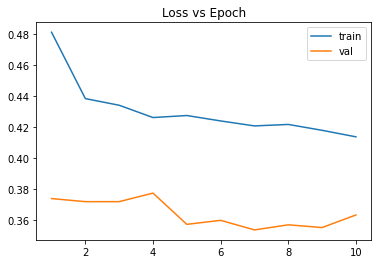

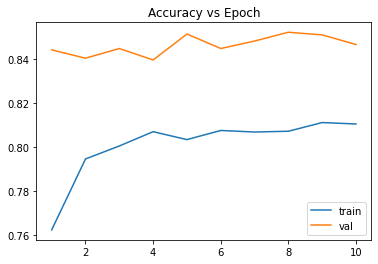

In [73]:
train_losses, val_losses = train(10, model, trainloader, valloader, optimizer, criterion) # train the model

In [74]:
# load best model
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

The low training accuracy in comparison with validation set accuracy here can be explained by dropout being active in the train epoch. Let's confirm this intuition by evaluating on the trainset.

In [76]:
loss, acc = evaluate_epoch(model, trainloader, criterion)
print(f'Loss on train data: {loss:.4f}')
print(f'Accuracy on train data: {100*acc:.2f}%')

100%|██████████| 1250/1250 [02:39<00:00,  7.82it/s]

Loss on train data: 0.3342
Accuracy on train data: 85.89%


Thus, our intuition was correct, and actual train set performance is quite close to the validation set performance. 

### Evaluate on the test set

In [75]:
loss, acc = evaluate_epoch(model, testloader, criterion)
print(f'Loss on test data: {loss:.4f}')
print(f'Accuracy on test data: {100*acc:.2f}%')

100%|██████████| 1563/1563 [03:19<00:00,  7.84it/s]

Loss on test data: 0.3429
Accuracy on test data: 85.19%


Thus the accuracy of the model is quite good, keeping in mind that we have used a lighter language model (DistilBERT). Performance on this model can also be further improved by tinkering with the classification layer parameters on top, and other hyperparameters like dropout probability and choice of optimizer and its learning rate.